In [1]:
!pip install timm umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=8512f30b8dccc83ae20987ed483f9e22481397b4b57afc94bb0035d21adf05bd
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!unzip /content/drive/MyDrive/dataset.zip

In [4]:
import os
import matplotlib.pyplot as plt
import random
import warnings


import cv2
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap


from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms

warnings.filterwarnings("ignore")

# Classes

In [5]:
class ImageEmbedder(nn.Module):
    def __init__(self,
                 base_model_path: str,
                 model_path: str,
                 embedding_size: int = 512,
                 freeze: bool = False,
                 device: str = 'cuda',
                 normalize: bool = True):
        super().__init__()

        #self.base_model = timm.create_model('efficientnet_b1', pretrained=True)

        self.base_model = torch.load(base_model_path, map_location=torch.device(device))

        self.internal_embedding_size = self.base_model.classifier[0].in_features
        self.base_model.classifier = nn.Linear(in_features=self.internal_embedding_size, out_features=embedding_size)
        self.normalize = normalize

        if freeze:
            for param in self.base_model.parameters():
                param.requires_grad = False
            self.base_model.classifier.requires_grad_(True)

        self.base_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

        self.base_model.to(device)

    def embed_image(self, image):
        return self.base_model(image)

    def save(self, model_path):
        torch.save(self.base_model.state_dict(), os.path.join(model_path, 'model.pth'))

    @torch.no_grad()
    def get_embeddings(self, image):

        out = self.base_model(image)

        if self.normalize:
            out = F.normalize(out, dim=1)

        return out.cpu().numpy()

    def forward(self, x):
        embedding = self.embed_image(x)

        if self.normalize:
            embedding = F.normalize(embedding, dim=1)

        return embedding



In [6]:
class EmotionsDataset(Dataset):
    def __init__(self, dataset_dir: str, img_size=(224, 224), emb_mode=True, model=None, sample_mode='arcface'):
        super(EmotionsDataset, self).__init__()

        self.dataset_root = dataset_dir
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=img_size),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.emb_mode = emb_mode
        self.model = model
        self.embeddings = list()
        self.sample_mode = sample_mode

        self.images, self.names, self.labels, self.sample_nums = self._load_list(self.dataset_root)
        self.classes = {'Neutral': 0, 'Anger': 1, 'Disgust': 2, 'Fear': 3, 'Happiness': 4, 'Sadness': 5, 'Surprise': 6, 'Other': 7}

    def _load_list(self, list_root):
        samples, sample_names, sample_labels, frame_nums = list(), list(), list(), list()
        files_list = os.listdir(list_root)

        for file in tqdm(files_list):
            if file.endswith('.jpeg'):
                # path, frame, label
                path = os.path.join(list_root, file)

                emb, sample, name, label, frame_num = self._load_samples_with_labels(path)

                samples.append(sample)
                sample_names.append(name)
                sample_labels.append(label)
                frame_nums.append(frame_num)
                self.embeddings.append(emb)

        return samples, sample_names, sample_labels, frame_nums

    def _load_samples_with_labels(self, path):
        name, class_label, frame_num = path.split('/')[-1].replace('.jpeg', '').split('_')

        if self.emb_mode:
            image = cv2.imread(path)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform is not None:
              image = self.transform(image)
            image = image.to('cuda')

            emb = self.model.get_embeddings(image.unsqueeze(0))

            emb = emb[0]

        return emb, path, name, class_label, frame_num

    def load_image(self, path):
        image = cv2.imread(path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
          image = self.transform(image)

        return image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        if self.emb_mode:
            return self.images[idx], int(self.labels[idx]), self.names[idx], int(self.sample_nums[idx])

        if self.sample_mode == 'triplet':
            anchor, anchor_label, anchor_name = self.load_image(self.images[idx]), int(self.labels[idx]), self.names[idx]

            positive_list = [self.images[i] for i in range(len(self.images)) if
                             i != idx and int(self.labels[i]) == anchor_label]
            negative_list = [self.images[i] for i in range(len(self.images)) if
                             self.names[i] != anchor_name and int(self.labels[i]) != anchor_label]

            positive = self.load_image(random.choice(positive_list))
            negative = self.load_image(random.choice(negative_list))

            return anchor, positive, negative, anchor_label

        if self.sample_mode == 'arcface':
            anchor, anchor_label, anchor_name = self.load_image(self.images[idx]), int(self.labels[idx]), self.names[idx]

            return anchor, anchor_label

        return self.images[idx], int(self.labels[idx]), self.names[idx], int(self.sample_nums[idx])



In [7]:
# compute interclass similarity
def compute_similarity(df: pd.DataFrame):
    a = np.array(df['embeddings'].to_list())
    result_matrix = a @ a.T

    out = np.ones(result_matrix.shape,dtype=bool)
    np.fill_diagonal(out,0)

    return result_matrix[out]

# Load model and dataset

In [117]:
model = ImageEmbedder('/content/drive/MyDrive/enet_b0_8_best_vgaf.pt', '/content/drive/MyDrive/experiments/ImageEmbedder_2024_01_19/loss_7.946173998860153/model.pth')
model.eval()

ImageEmbedder(
  (base_model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), s

In [118]:
eval = EmotionsDataset('/content/dataset/val', emb_mode=True, model=model)
    #
pd.DataFrame({'label': eval.labels, 'video_name': eval.names, 'embeddings': eval.embeddings, 'path': eval.images}).to_parquet('eval_1.parquet')

100%|██████████| 10953/10953 [02:32<00:00, 71.77it/s]


In [119]:
df = pd.read_parquet('eval_1.parquet')

In [120]:
df

,label,video_name,embeddings,path
0,5,9-15-1920x1080.mp4,"[0.07091857, 0.054240804, 0.028472807, -0.0151...",/content/dataset/val/9-15-1920x1080.mp4_5_2880...
1,0,112-30-640x360.mp4,"[-0.05477324, -0.022621352, -0.041139446, -0.0...",/content/dataset/val/112-30-640x360.mp4_0_5700...
2,5,9-15-1920x1080.mp4,"[0.071571566, 0.08593737, 0.07304015, 0.021352...",/content/dataset/val/9-15-1920x1080.mp4_5_3450...
3,0,112-30-640x360.mp4,"[-0.048796654, -0.0048867245, -0.010741012, -0...",/content/dataset/val/112-30-640x360.mp4_0_560....
4,5,9-15-1920x1080.mp4,"[-0.053246725, -0.07172881, -0.036152422, 0.02...",/content/dataset/val/9-15-1920x1080.mp4_5_2570...
...,...,...,...,...
10948,5,9-15-1920x1080.mp4,"[-0.05193565, -0.03570084, -0.035597164, 0.035...",/content/dataset/val/9-15-1920x1080.mp4_5_2120...
10949,0,388.mp4,"[-0.01811967, -0.02378018, -0.041413035, -0.01...",/content/dataset/val/388.mp4_0_1410.jpeg
10950,4,9-15-1920x1080.mp4,"[-0.042232454, -0.07151393, -0.0781488, 0.0274...",/content/dataset/val/9-15-1920x1080.mp4_4_4533...
10951,0,388.mp4,"[-0.035833422, -0.016729685, -0.046696045, -0....",/content/dataset/val/388.mp4_0_2990.jpeg


In [128]:
classes = {'Neutral': 0, 'Anger': 1, 'Disgust': 2, 'Fear': 3, 'Happiness': 4, 'Sadness': 5, 'Surprise': 6, 'Other': 7}

In [129]:
classes_encoder = {value: key for key, value in classes.items()}

In [130]:
df['label'] = df['label'].astype(int)

ValueError: invalid literal for int() with base 10: 'Sadness'

In [131]:
df['label'] = df['label'].replace(classes_encoder)

In [132]:
classes_encoder

{0: 'Neutral',
 1: 'Anger',
 2: 'Disgust',
 3: 'Fear',
 4: 'Happiness',
 5: 'Sadness',
 6: 'Surprise',
 7: 'Other'}

# Compute similarity

In [133]:
metric_dict = dict()

for name, group in df.groupby('label'):
    metric_dict[name] = compute_similarity(group).mean()

In [134]:
# class similarity
metric_dict

{'Anger': 0.22532462,
 'Disgust': 0.28167403,
 'Fear': 0.23087104,
 'Happiness': 0.4040714,
 'Neutral': 0.5797374,
 'Other': 0.48654935,
 'Sadness': 0.25549603,
 'Surprise': 0.25647038}

In [135]:
metric_video_dict = dict()

for name, group in df.groupby('video_name'):
    metric_video_dict[name] = compute_similarity(group).mean()

In [136]:
# video similarity
metric_video_dict

{'112-30-640x360.mp4': 0.90201133,
 '13-30-1920x1080.mp4': 0.5310099,
 '139-14-720x480.mp4': 0.83760136,
 '25-25-600x480.mp4': 0.688048,
 '27-60-1280x720.mp4': 0.58992475,
 '28-30-1280x720-1.mp4': 0.7862194,
 '35-30-1920x1080.mp4': 0.47046453,
 '354.mp4': 0.8631432,
 '365.mp4': 0.8227639,
 '369.mp4': 0.83962625,
 '381.mp4': 0.553736,
 '384.mp4': 0.6744428,
 '385.mp4': 0.84570694,
 '387.mp4': 0.87748325,
 '388.mp4': 0.86399865,
 '429.mp4': 0.56285137,
 '439.mp4': 0.8068399,
 '447.mp4': 0.67381555,
 '57-25-426x240.mp4': 0.9492615,
 '87-25-1920x1080.mp4': 0.55220854,
 '9-15-1920x1080.mp4': 0.2546761,
 'video1.mp4': 0.6493145,
 'video2.mp4': 0.5249434,
 'video34.mp4': 0.57323086,
 'video73.mp4': 0.4377686}

# Similarity scores plot

In [137]:
neutral = df[(df['label']=='Happiness')]['embeddings'].to_list()

In [138]:
anger = df[(df['label']=='Surprise')]['embeddings'].to_list()

In [139]:
#similarity between opposite emotions (neutral and anger)
negative_score = (np.array(neutral) @ np.array(anger).T).reshape(len(neutral) * len(anger))

In [140]:
positive_score = compute_similarity(df[(df['label']=='Happiness')])

In [141]:
negative_score

array([ 0.4587569 , -0.33575287,  0.73257285, ...,  0.04904635,
        0.8661716 ,  0.5888016 ], dtype=float32)

In [142]:
def compute_similarity_vector(df: pd.DataFrame):
    a = np.array(df['embeddings'].to_list())
    result_matrix = a @ a.T

    out = np.ones(result_matrix.shape,dtype=bool)
    np.fill_diagonal(out,0)

    return result_matrix[out]

In [143]:
positive_score

array([ 0.33256423,  0.5540172 , -0.08287441, ...,  0.22225969,
        0.73076504,  0.06530666], dtype=float32)

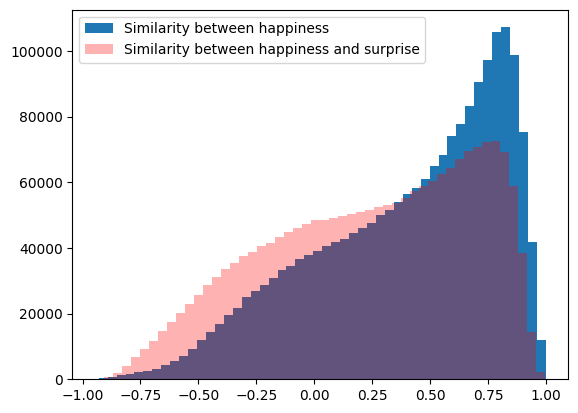

In [144]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(positive_score[:len(negative_score)], label='Similarity between happiness', bins=50)
_ = ax.hist(negative_score[:len(positive_score)], color='red', alpha=.3, label='Similarity between happiness and surprise', bins=50)

ax.legend()

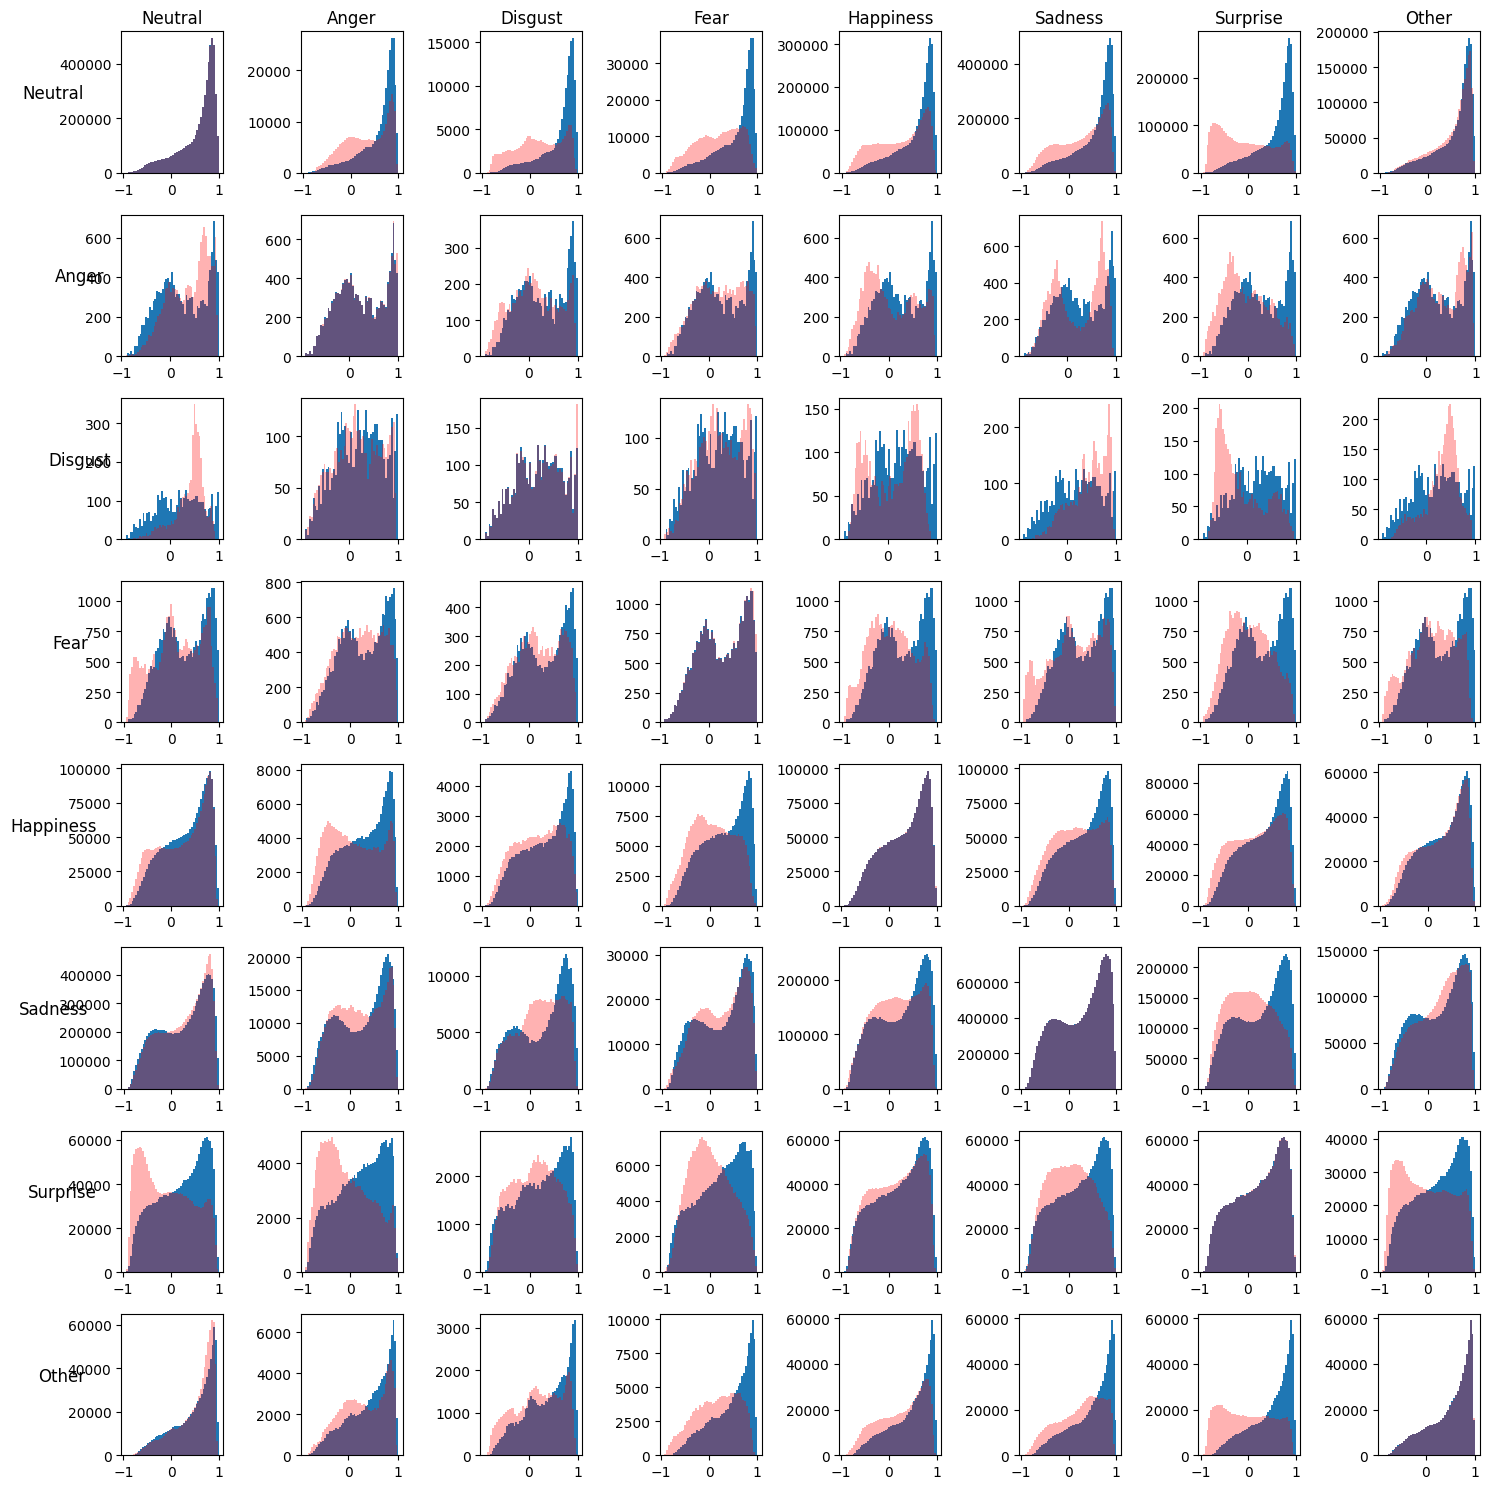

In [111]:
fig, axs = plt.subplots(8, 8, figsize=(15, 15))

for ax, col in zip(axs[0], classes_encoder.values()):
    ax.set_title(col)

for ax, row in zip(axs[:,0], classes_encoder.values()):
    ax.set_ylabel(row, rotation=0, size='large')

for key, value in classes_encoder.items():
    for key_1, value_1 in classes_encoder.items():
        neutral = df[(df['label']==value)]['embeddings'].to_list()
        anger = df[(df['label']==value_1)]['embeddings'].to_list()

        positive_score = compute_similarity_vector(df[(df['label']==value)])
        negative_score = (np.array(neutral) @ np.array(anger).T).reshape(len(neutral) * len(anger))

        _ = axs[key, key_1].hist(positive_score[:len(negative_score)], label=f'Similarity between {value}', bins=50)
        _ = axs[key, key_1].hist(negative_score[:len(positive_score)], color='red', alpha=.3, label=f'Similarity between {value} and {value_1}', bins=50)
        #_ = axs[key, key_1].legend()


fig.tight_layout()
plt.show()

#UMAP


In [145]:
reducer = umap.UMAP(metric='cosine', random_state=3, n_neighbors=25)
reducer.fit(pd.DataFrame(df.embeddings.tolist(), index=df.embeddings))

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=25, random_state=3, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [146]:
embedding = reducer.transform(pd.DataFrame(df.embeddings.tolist(), index=df.embeddings))
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(10953, 2)

In [147]:
color = {label: idx for idx, label in enumerate(df['label'].unique())}

In [148]:
df['color'] = df['label'].replace(color)

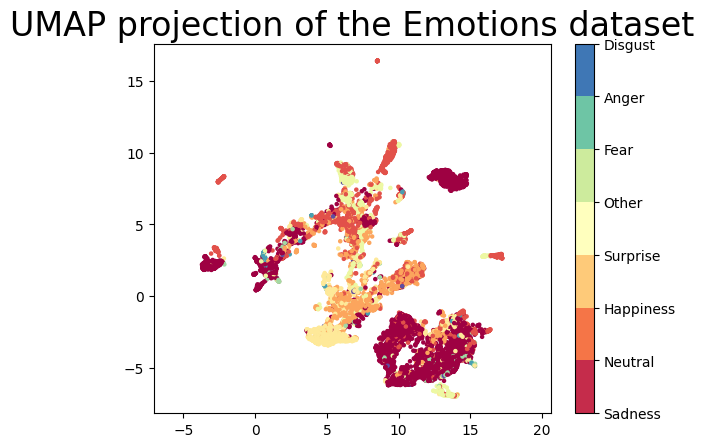

In [150]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=df.color, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(boundaries=np.arange(8))
cbar.ax.set_yticklabels(list(color.keys()))
plt.title('UMAP projection of the Emotions dataset', fontsize=24);